In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


1. Split training data in, train and validation set. 
   Check distribution of dependent in both the sets, it should align. 
   For more robust split, PSI can be calculated.
2. **Baseline model.**
    Feature Engineering <br>
    Confirm linear distribution on features or transformations. (square, root, log, 1/3) <br>
    Cap values at floor of 0. Essentially making all negative values as 0 and only keeping positives as is.<br>
    Note: Missing values could mean data category and could be predictive feature separating the dependent.<br>
    When too many features and calculating correlation is not possible.<br>
    Calculate R2/ K-S for each independent and select top 5-7 by forward feature selection from top ~90.<br>
    Restrictions for features; <br>
    a. VIF < 2/3<br>
    b. Contribution of each feature (any shouldn't be more than 50%)<br>
    c. Significance<br>
    d. Rank order. - Predictions should follow rank order, if not add more features<br>
    Else: Select one feature from each cluster of correlated features.<br>
    Best feature from each cluster by best R2.
    
    
3. **Final model.**
    Feature Engineering/ Selection<br>
    Throw all the features to XGBoost or Random Forest. and reduce number of features by selecting top features, this on small sample ~100k<br>
    Variable Reduction is done in 2 or more steps. Depends how manyvariables you are reducing. Feature selection is done based on model performance later.<br>
    Perform broad grid search using small sample, 100k.<br>
    Perform narrow grid search based on best parameters from broad search.<br>
    Most important parameter **Min Child Weight** this would help take care of model overfitting. Keeping the trees shorter hence generalising better.<br>

    Measure performance on validation set (ITV)<br>
    Also on hold-out set (OTV)<br>
    If performance within 5-10% range then model is fine.<br>
    If underperforming on ITV, then overfitting. rebuild model by tuning parameters. Shorten tree depth. reduce learning rate, increase min child weight.<br>
    Rank Order: If predictions not sharing rank order then re-do the model, may be add more variable. Typically adding variables will improve rank order. Alt method    would be selecting/keeping variables in the model which do not disturb the rank order between pred vs actual
    
4. **Compare with linear model.**
    Performance of final model should be better than the linear model, only reason this does not hold true is when all features are already linear and hence linear model explains everything and leaving not scope for XGBoost to shine. Or also when boosting algorithm is not adding new to the model. Model is not able to learn anything from the errors

     
     

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import pandas as pd
train_df = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
train_df.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [7]:
df_desc = train_df.describe()
df_desc

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

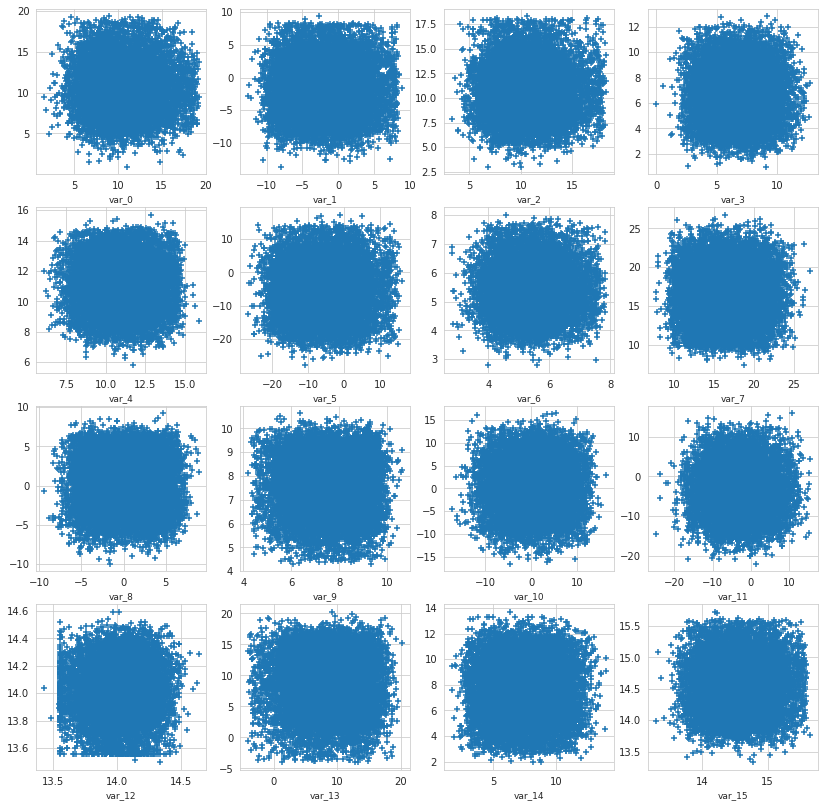

In [9]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

In [10]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

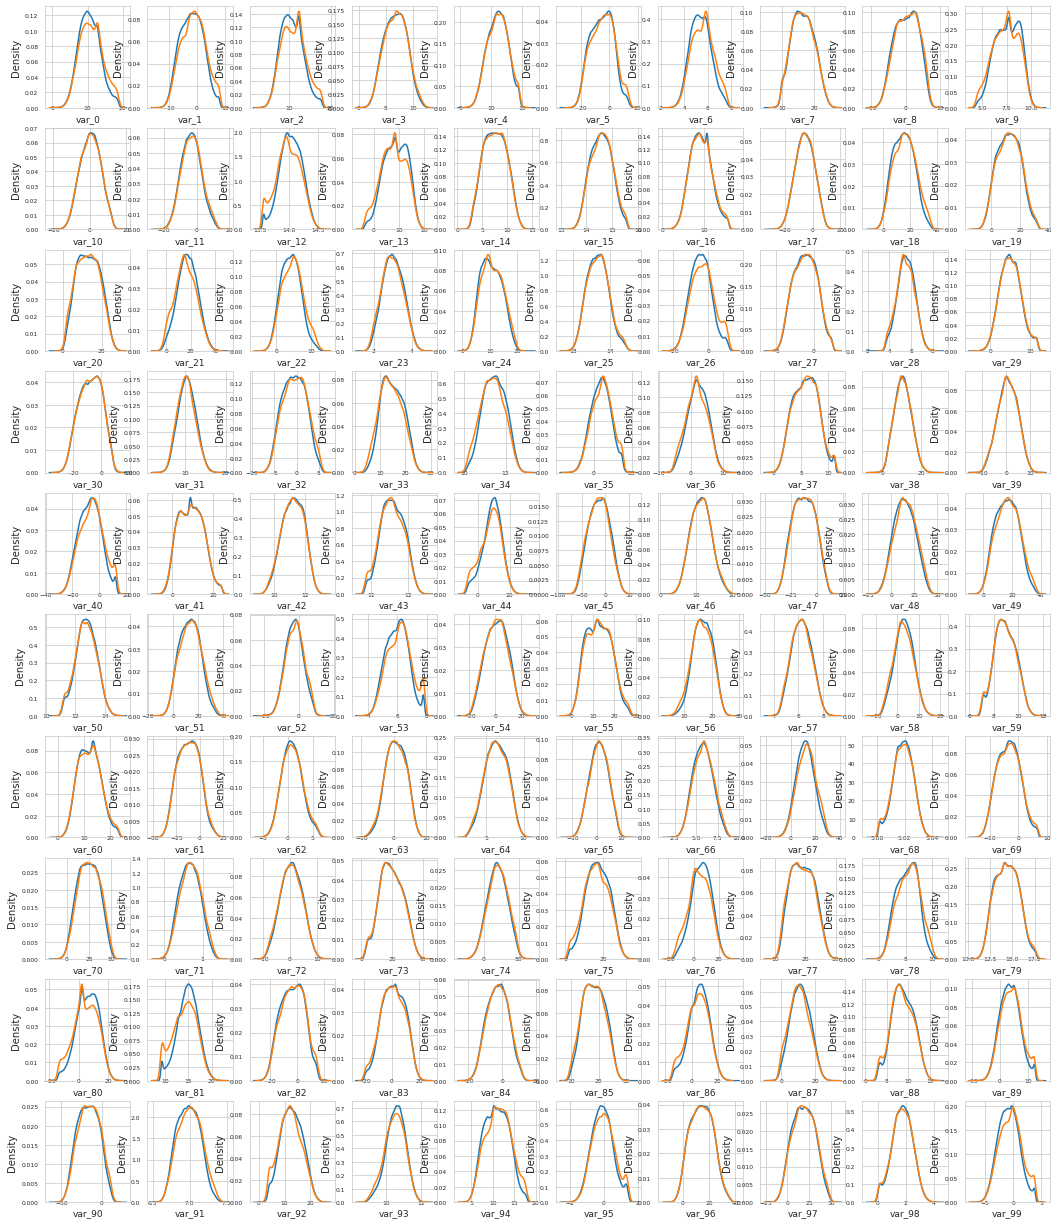

In [11]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

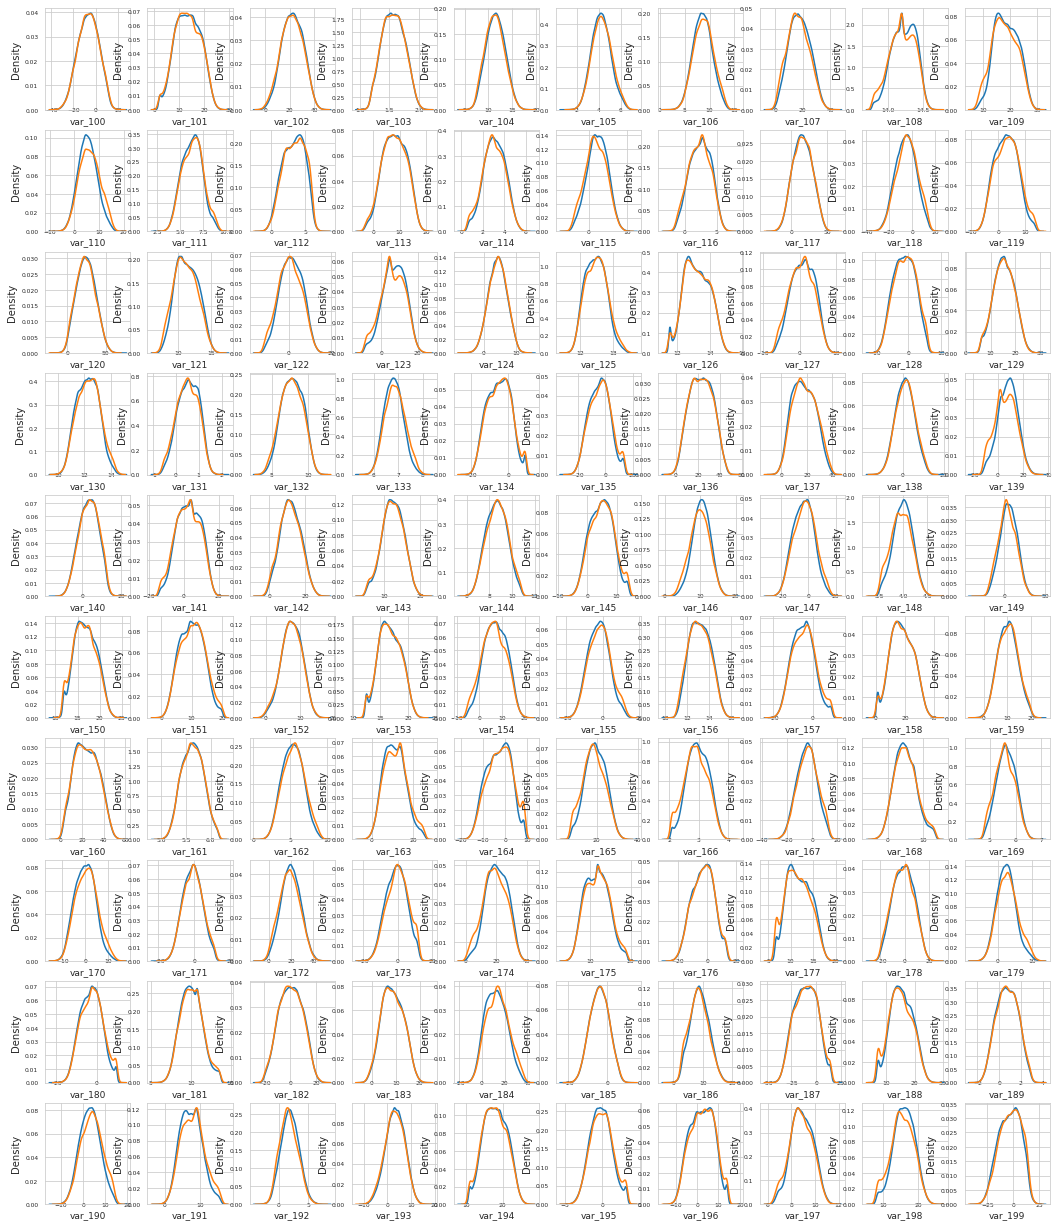

In [12]:
features = train_df.columns.values[102:]
plot_feature_distribution(t0, t1, '0', '1', features)

In [13]:
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,var_109,var_126,1.313947e-07
1,var_126,var_109,1.313947e-07
2,var_177,var_100,3.116544e-07
3,var_100,var_177,3.116544e-07
4,var_150,var_116,6.628008e-07
5,var_116,var_150,6.628008e-07
6,var_173,var_176,1.318335e-06
7,var_176,var_173,1.318335e-06
8,var_109,var_157,2.494615e-06
9,var_157,var_109,2.494615e-06


In [13]:
correlations.tail(10)

,level_0,level_1,0
9890,var_193,var_172,0.008163
9891,var_172,var_193,0.008163
9892,var_162,var_127,0.008555
9893,var_127,var_162,0.008555
9894,var_122,var_132,0.008956
9895,var_132,var_122,0.008956
9896,var_146,var_169,0.009071
9897,var_169,var_146,0.009071
9898,var_183,var_189,0.009359
9899,var_189,var_183,0.009359


Maximum correlation we see is 0.009, which is not significant. Hence assuming no correlation between indepedent variables

In [34]:
## Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

try: 
    vif_data = pd.read_csv('VIF.csv')
except FileNotFoundError:
    features = train_df.columns[2:]
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i)
                              for i in range(len(features))]
    
    vif_data.to_csv('VIF.csv', index = False)

In [38]:
vif_data.sort_values(by = 'VIF', ascending = False, inplace = True)  
print(vif_data.head(10))

     feature           VIF
68    var_68  25189.447705
108  var_108   6829.523665
12    var_12   5399.658645
25    var_25   2284.187678
91    var_91   2091.221665
125  var_125   1539.468184
43    var_43   1395.679451
15    var_15   1251.785220
161  var_161    668.802411
34    var_34    447.083062


In [16]:
print(len(vif_data.loc[vif_data.VIF > 2]))

66


In [17]:
vif_data.loc[vif_data.VIF > 2]

,feature,VIF
8,var_108,2878.665930
25,var_125,1339.361518
61,var_161,632.472471
48,var_148,389.374726
33,var_133,321.033869
...,...,...
45,var_145,2.542908
17,var_117,2.467138
31,var_131,2.426358
23,var_123,2.327168


# Building logistic regression model against each variable and calculating ks value to rank best variables

### Scaling data

In [20]:
from sklearn import preprocessing

features = train_df.columns[2:]
scaler = preprocessing.StandardScaler().fit(train_df[features])
X_scaled = scaler.transform(train_df[features])

## Creating dataframe with scaled values with same format 
train_df_scaled = pd.DataFrame()
train_df_scaled['ID_code'] = train_df['ID_code']
train_df_scaled['target'] = train_df['target']
train_df_scaled[features] = X_scaled
train_df_scaled.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,...,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135
1,train_1,0,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,...,0.966611,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685
2,train_2,0,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,...,-0.072093,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681
3,train_3,0,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,...,0.270216,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502
4,train_4,0,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,...,-1.036191,0.688988,-1.405987,1.468536,-1.501101,-0.958473,0.297627,0.645537,0.706318,-0.525375


In [21]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import ks_2samp


kss = []
features = train_df.columns[2:]
for feature in features:
    X = train_df_scaled[feature].to_numpy().reshape(-1, 1)
    y = train_df_scaled['target']
    clf = LogisticRegression(random_state=0).fit(X, y)
    probs = clf.predict_proba(X)
    res = pd.DataFrame({'p': probs[:,1], 'y' : y})

    ks = ks_2samp(res.loc[res.y==0,"p"], res.loc[res.y==1,"p"]).statistic
    kss.append(ks)
    
ks_df = pd.DataFrame({'feature':features, 'ks': kss})
ks_df.sort_values(by = 'ks', ascending = False, inplace = True)
print(ks_df.head())

     feature        ks
81    var_81  0.120792
139  var_139  0.117404
6      var_6  0.099717
110  var_110  0.094883
12    var_12  0.091907


Now that we have most important features for logistic regression, next step is to build logistic regression by adding features in forward addition and keep track of KS metric. Stop when metric stops improving.

Features requirements for logistic regression.
1. No feature should contribute more than 50%
2. Not correlated, VIF < 2-3

In [22]:
## Top 10 features
ks_df.feature.to_list()[:10]

['var_81',
 'var_139',
 'var_6',
 'var_110',
 'var_12',
 'var_76',
 'var_146',
 'var_80',
 'var_26',
 'var_2']

In [23]:
## Checking KS using all variables
## Scikit Learn Logistic Regression

X = train_df_scaled[features]
y = train_df_scaled['target']
clf = LogisticRegression(random_state=0).fit(X_scaled, y)
probs = clf.predict_proba(X)
res = pd.DataFrame({'p': probs[:,1], 'y' : y})

ks = ks_2samp(res.loc[res.y==0,"p"], res.loc[res.y==1,"p"]).statistic
print('KS using Scikit and all features: ',ks)

#print(res.head())

KS using Scikit and all features:  0.5628454933976785


In [24]:
import statsmodels.api as sm

## statsmodels Logistic Regression
X = train_df_scaled[features]
y = train_df_scaled['target']
log_reg = sm.Logit(y, X_scaled).fit()

probs = log_reg.predict(X_scaled)
yhat = list(map(round, probs))
res = pd.DataFrame({'p': probs, 'y' : y})
ks = ks_2samp(res.loc[res.y==0,"p"], res.loc[res.y==1,"p"]).statistic
print('KS using StatsModels and all features: ',ks)

Optimization terminated successfully.
         Current function value: 0.659079
         Iterations 5
KS using StatsModels and all features:  0.5624473193822616


In [42]:
#log_reg.summary()

In [46]:
ks_vif_features =  vif_data.merge(ks_df, on = 'feature')
ks_vif_features = ks_vif_features.loc[ks_vif_features.VIF < 3]
ks_vif_features.sort_values(by = 'ks', ascending = False)
ks_vif_features.head(10)

,feature,VIF,ks
121,var_154,2.980142,0.057105
122,var_74,2.915518,0.030230
123,var_184,2.877827,0.067697
124,var_192,2.704120,0.070170
125,var_48,2.671408,0.045085
126,var_90,2.586124,0.037185
127,var_145,2.544675,0.037456
128,var_117,2.468353,0.009709
129,var_131,2.427640,0.045631
130,var_47,2.392218,0.012751


In [59]:
from statsmodels.tools.tools import add_constant
n = 10
#topn = ks_df.feature.to_list()[:n]

for i in range(n):
    topn = ks_vif_features.feature.to_list()[:i+1]
    y = train_df['target']
    X_scaled = train_df_scaled[topn]
    X_scaled = add_constant(X_scaled)
                                         
    log_reg = sm.Logit(y, X_scaled).fit()
    probs = log_reg.predict(X_scaled)
    
    yhat = list(map(round, probs))
    res = pd.DataFrame({'p': probs, 'y' : y})
    ks = ks_2samp(res.loc[res.y==0,"p"], res.loc[res.y==1,"p"]).statistic    
    
    print(f'{i} {topn} ks: {ks}')
    print('VIF: \n',vif_data.loc[vif_data.feature.isin(topn)])

Optimization terminated successfully.
         Current function value: 0.325097
         Iterations 6
0 ['var_154'] ks: 0.05710454587575742
VIF: 
      feature       VIF
154  var_154  2.980142
Optimization terminated successfully.
         Current function value: 0.324897
         Iterations 6
1 ['var_154', 'var_74'] ks: 0.06525225481310715
VIF: 
      feature       VIF
154  var_154  2.980142
74    var_74  2.915518
Optimization terminated successfully.
         Current function value: 0.323745
         Iterations 6
2 ['var_154', 'var_74', 'var_184'] ks: 0.08972590487199927
VIF: 
      feature       VIF
154  var_154  2.980142
74    var_74  2.915518
184  var_184  2.877827
Optimization terminated successfully.
         Current function value: 0.322819
         Iterations 6
3 ['var_154', 'var_74', 'var_184', 'var_192'] ks: 0.10837513685802241
VIF: 
      feature       VIF
154  var_154  2.980142
74    var_74  2.915518
184  var_184  2.877827
192  var_192  2.704120
Optimization terminated suc

In [55]:
res['log_odds'] = np.log(probs/(1-probs))
res[topn] = train_df[topn]

## Checking for linearity with log-odds 

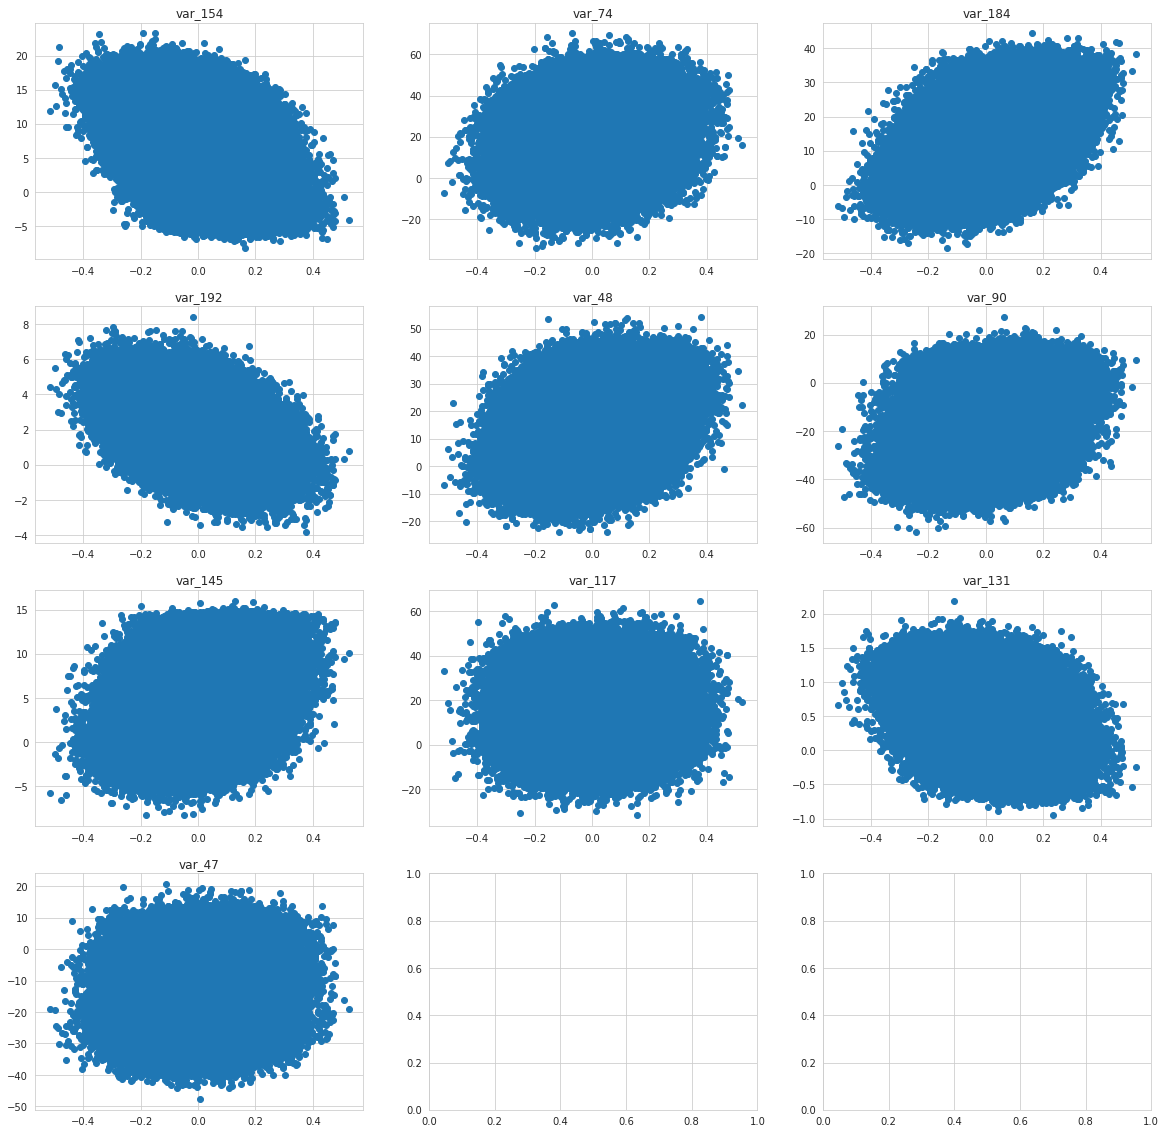

In [58]:
fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_figheight(20)
fig.set_figwidth(20)
i = 0
for i, feature in enumerate(topn):
    plt.subplot(4, 3, i+1)
    plt.scatter(x = res['log_odds'], y = res[feature])
    plt.title(feature)

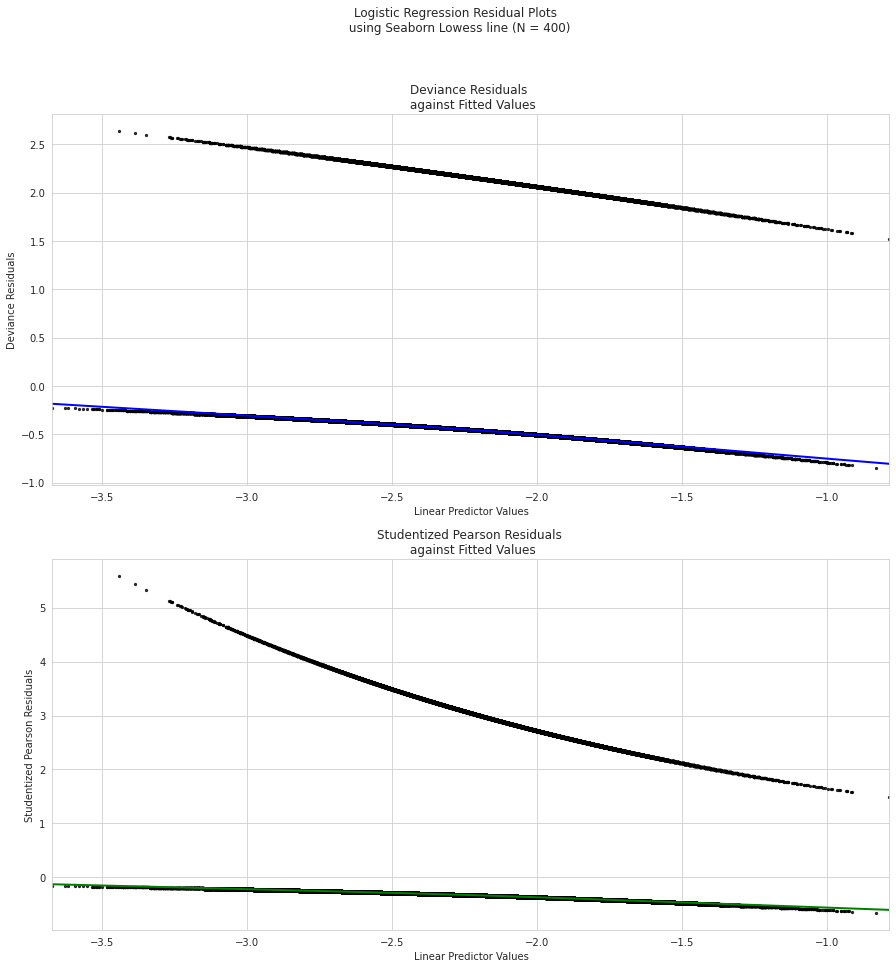

In [60]:

## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line")


# Deviance Residuals
sns.regplot(log_reg.fittedvalues, log_reg.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(log_reg.fittedvalues, log_reg.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

In [48]:

features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

In [49]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9537,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8876,11.4522


In [50]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


In [51]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [52]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [53]:
folds = StratifiedKFold(n_splits=5)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.891051	valid_1's auc: 0.868582
[2000]	training's auc: 0.90772	valid_1's auc: 0.881365
[3000]	training's auc: 0.918531	valid_1's auc: 0.889387
[4000]	training's auc: 0.925895	valid_1's auc: 0.893362
[5000]	training's auc: 0.931655	valid_1's auc: 0.895099
[6000]	training's auc: 0.936744	valid_1's auc: 0.896426
[7000]	training's auc: 0.941228	valid_1's auc: 0.897178
[8000]	training's auc: 0.945292	valid_1's auc: 0.897649
[9000]	training's auc: 0.949059	valid_1's auc: 0.897867
[10000]	training's auc: 0.952655	valid_1's auc: 0.898057
[11

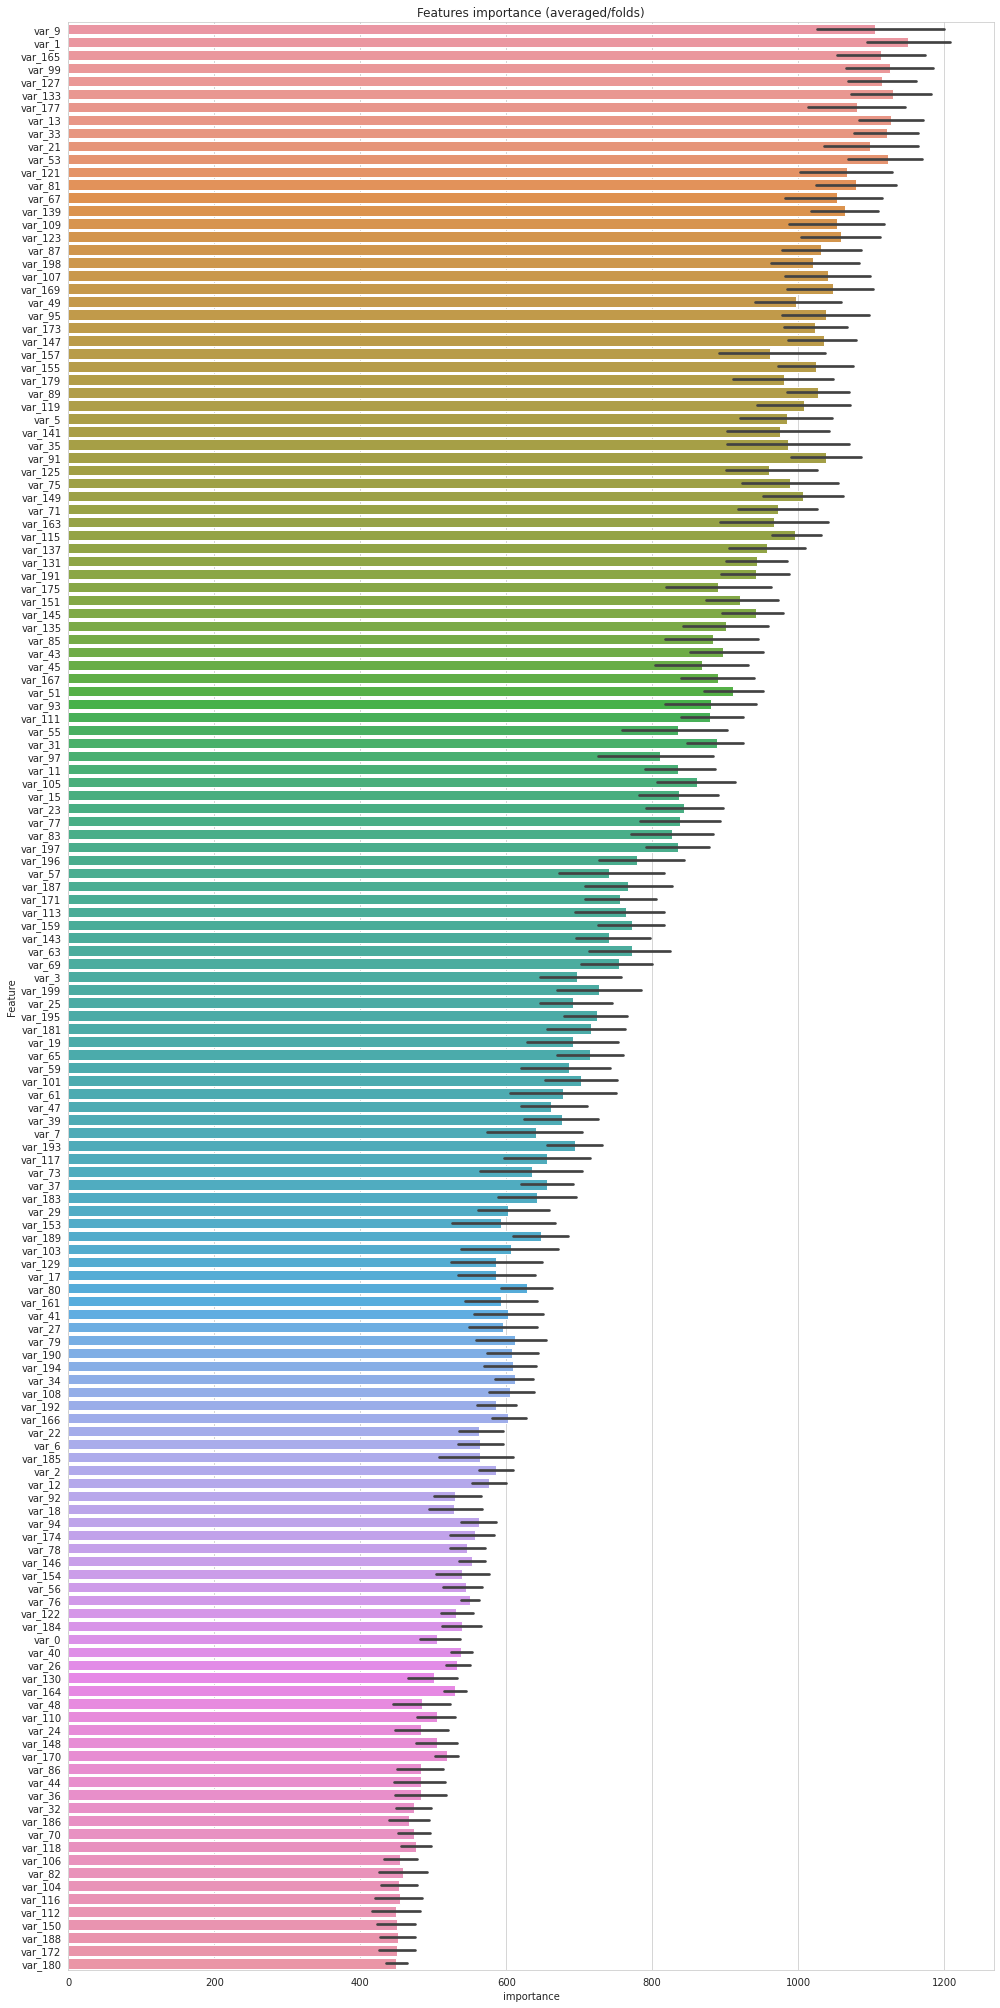

In [54]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

**Using only best 100 features to see the performance**

In [ ]:
folds = StratifiedKFold(n_splits=5)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][best_features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][best_features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][best_features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = best_features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[best_features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))